In [1]:
import os, numpy as np, tensorflow as tf, tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TF:", tf.__version__)

TF: 2.19.0


# Cargamos el dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/stl10")
print("Dataset descargado en:", path)

Using Colab cache for faster access to the 'stl10' dataset.
Dataset descargado en: /kaggle/input/stl10


In [3]:
def load_image_paths(base_path, split):
    folder = os.path.join(base_path, split)
    imgs = sorted([
        os.path.join(folder, fname)
        for fname in os.listdir(folder)
        if fname.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    return imgs

unlabeled_paths = load_image_paths(path, "unlabeled_images")
train_paths = load_image_paths(path, "train_images")

print("Unlabeled:", len(unlabeled_paths))
print("Train:", len(train_paths))

Unlabeled: 100000
Train: 5000


In [4]:
train_subset = unlabeled_paths[:20000]   # 20,000 imágenes
val_subset   = train_paths[:1000]        # 1,000 imágenes

print(len(train_subset), len(val_subset))

20000 1000


# Cargamos el modelo de segmentación

In [5]:
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import torch
import numpy as np
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = AutoModelForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

In [6]:
def segformer_mask(img_pil):
    inputs = processor(images=img_pil, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits  
    upsampled = torch.nn.functional.interpolate(
        logits,
        size=img_pil.size[::-1],
        mode="bilinear",
        align_corners=False
    )
    mask = upsampled.argmax(1)[0].cpu().numpy()  
    return mask

In [9]:
def ade_to_9(c):
    # cielo
    if c in [2,3,4,5]: return 1

    # vegetación
    if c in [6,7,8,9,10]: return 2

    # Agua,rio,mar
    if c in [11,12,13,14]: return 3

    # Animales
    if 15 <= c <= 33: return 4

    # Personas
    if 34 <= c <= 50: return 5

    # Vehículos
    if 50 <= c <= 70: return 6

    # Edificios, casas
    if 71 <= c <= 150: return 7

    # fondo
    return 0

In [10]:
def prepare_mask(mask_150, size=128, num_classes=9):
    mask_resized = cv2.resize(mask_150, (size, size), interpolation=cv2.INTER_NEAREST)
    mask_9 = np.vectorize(ade_to_9)(mask_resized)
    onehot = np.eye(num_classes)[mask_9]
    onehot = onehot.transpose(2,0,1)
    return onehot.astype(np.float32)

# Ejecutamos la segmentación

In [11]:
SAVE_DIR = "masks"
os.makedirs(SAVE_DIR, exist_ok=True)

splits = {
    "train": train_subset,
    "val":   val_subset
}

for split, paths in splits.items():
    out_dir = os.path.join(SAVE_DIR, split)
    os.makedirs(out_dir, exist_ok=True)

    for i, p in tqdm(list(enumerate(paths)), desc=f"Segmentando {split}"):
        img = Image.open(p).convert("RGB")

        # Segmentamos con SegFormer
        mask_150 = segformer_mask(img)

        # Convertimos a 9 clases y one-hot
        mask_oh = prepare_mask(mask_150)

        # Guardamos
        np.save(os.path.join(out_dir, f"{i}.npy"), mask_oh)

Segmentando val: 100%|██████████| 1000/1000 [00:43<00:00, 23.10it/s]


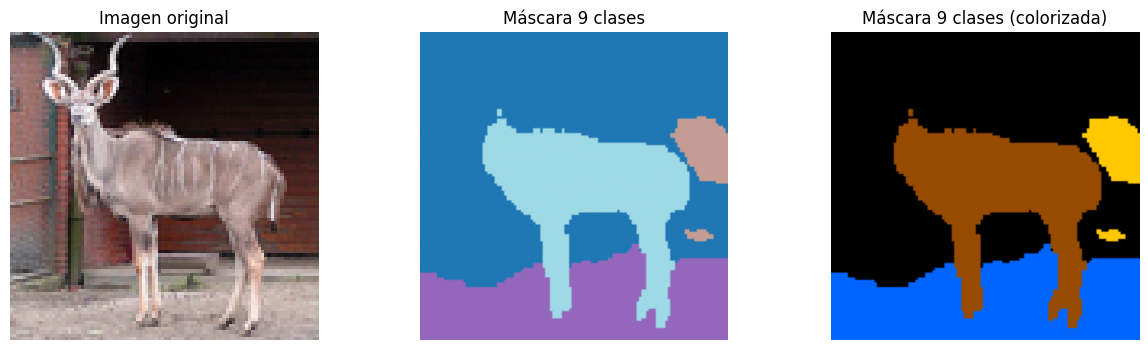

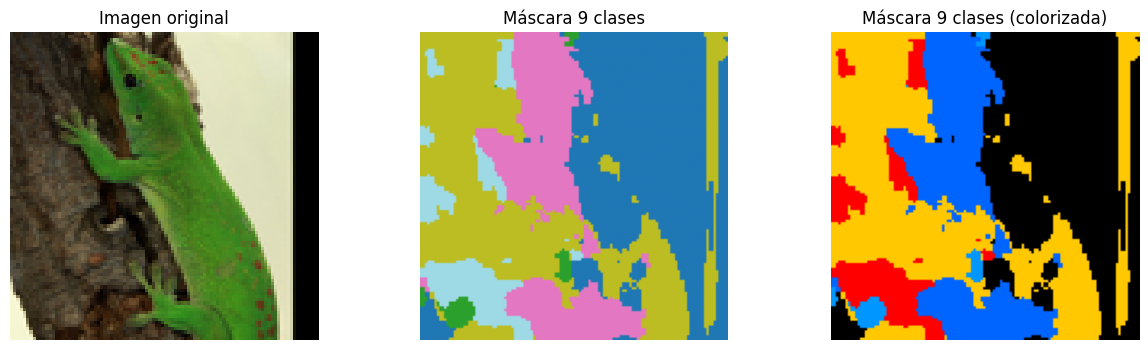

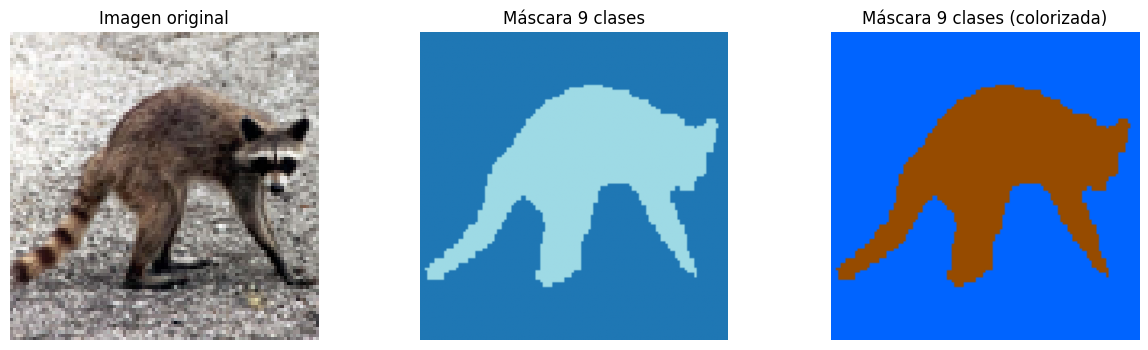

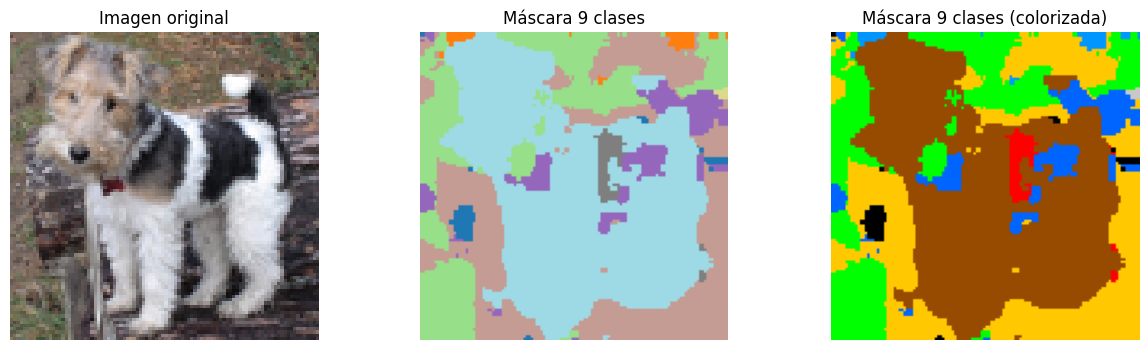

In [12]:
# Ejemplos

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Colormap simple para 9 clases
colors = np.array([
    [0, 0, 0],        # fondo
    [0, 150, 255],    # cielo
    [0, 255, 0],      # vegetación
    [0, 100, 255],    # agua
    [255, 200, 0],    # animal
    [255, 0, 0],      # persona
    [200, 200, 200],  # vehículo
    [150, 75, 0],     # interior/estructuras
], dtype=np.uint8)

def colorize_mask(mask9):
    mask_color = colors[mask9]
    return mask_color

for i in range(4):
    example_img = Image.open(train_subset[i]).convert("RGB")
    example_mask = np.load(f"./masks/train/{i}.npy")  

    # Convertimos el one-hot a clases enteras
    mask_class = np.argmax(example_mask, axis=0)
    mask_color = colorize_mask(mask_class)

    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.imshow(example_img)
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask_class, cmap="tab20")
    plt.title("Máscara 9 clases")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mask_color)
    plt.title("Máscara 9 clases (colorizada)")
    plt.axis("off")

    plt.show()

In [13]:
!zip -r masks.zip masks
from google.colab import files
files.download("masks.zip")

Se han truncado las últimas 5000 líneas del flujo de salida.
  adding: masks/train/1813.npy (deflated 99%)
  adding: masks/train/8763.npy (deflated 100%)
  adding: masks/train/12920.npy (deflated 100%)
  adding: masks/train/19130.npy (deflated 100%)
  adding: masks/train/3146.npy (deflated 100%)
  adding: masks/train/2405.npy (deflated 100%)
  adding: masks/train/11768.npy (deflated 100%)
  adding: masks/train/12470.npy (deflated 100%)
  adding: masks/train/9415.npy (deflated 100%)
  adding: masks/train/12075.npy (deflated 100%)
  adding: masks/train/8876.npy (deflated 100%)
  adding: masks/train/1486.npy (deflated 100%)
  adding: masks/train/2850.npy (deflated 100%)
  adding: masks/train/8912.npy (deflated 100%)
  adding: masks/train/14859.npy (deflated 100%)
  adding: masks/train/10436.npy (deflated 100%)
  adding: masks/train/6238.npy (deflated 100%)
  adding: masks/train/14329.npy (deflated 100%)
  adding: masks/train/6607.npy (deflated 100%)
  adding: masks/train/12375.npy (deflat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>